# Similarity Analysis of Robert Burns' Poems

## Context

This report provides an analysis of the complete works by Scottish poet Robert Burns (1759-96). More specifically, it investigates the extent of similarity between the works in this corpus using statistical analysis of their structure (number of lines, number of stanzas etc.) and similarity analysis of the content using Machine Learning techniques.

Firstly, the relevant data was gathered from www.bbc.co.uk/arts/robertburns using Python web scraping techniques. The data was then, partially in the same step, processed to a usable format for the statistical and similarity analyses. After that, the statistical analysis and visualisation of the data was carried out resulting in descriptive statistics and frequency distributions of features of interest. This was conducted for the full corpus, as well as for the most popular works and other works individually. Subsequently, the text document similarity of the corpus was assessed using several different distance measures. The results of the similarity analyses - in the form of similarity matrices, average similarity scores, and most similar works - were then compared. Taking into account the key findings from the statistical and similarity analysis, final conlusions were drawn as to the degree of similarity between Burns' works, and potential for further work outlined.

### Data Source

In order to asses the degree of similarity between Robert Burns' works, access to the full text for as many of his work as possible was quintessential. The chosen data source for this purpose was an area of the BBC website dedicated to the works of Robert Burns (www.bbc.co.uk/arts/robertburns). Not only was this the number one search result for 'robert burns poems list', but full text and audio recordings from more than 700 works were available, many of them associated with the year of composition, day of the year, theme, and a location. Furthermore, the website provided a list of 15 works that the BBC experts classified as 'popular works'. Having all this information on the same domain, with a similar DOM structure, facilitated a streamlined web scraping process and offered much potential for the current analysis and additional analyses in the future. It has to be noted that this may not be the most complete source of Burns' works, nor was the methodology behind the 15 'popular works' revealed so that the results of the analysis may differ when using a different, more comprehensive data source.

## Data Set

The data from the BBC website was obtained using web scraping techniques, specifically using the Python libraries requests and bs4 in a reusable function. As a first step, a list of the href's/URL's of the pages containing the full text of the 700+ works was retrieved. Each page was then scraped in turn to retrieve the text which was stored in a dictionary of dictionaries alongside the title. Additionally, further processing of the raw text resulted in a cleaned version of the text, as well as the number of paragraphs, number of lines, number of words, number of letters and average number of lines per paragraph, words per line, and letters per word. The year of composition of the work was stored in the same dictionary, obtained by scraping pages that list the works by year and matching the years with the works in the dictionary. In a similar process, it was established whether a work was listed among the 'popular works'. As a last step, the dictionary with the works and corresponding features was turned into a Pandas DataFrame. The resulting Pandas DataFrame contains 715 observations and 12 features. Out of the 12 features, 7 are of data type integer or float, 4 of string, and 1 of boolean.

## Data Collection and Processing

In [65]:
import requests
from bs4 import BeautifulSoup
import pickle
import sys
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [66]:
def get_soup(url):
    """Generates a BeautifulSoup soup object for a given url

    Parameters
    ----------
    url : str
        The url to be used in generating a soup object

    Returns
    -------
    soup : bs4.BeautifulSoup object
        A soup object generated by BeautifulSoup for the given 'url' parameter
    """

    request = requests.get(url)
    soup = BeautifulSoup(request.text, "html.parser")

    return soup

In [67]:
# Get urls for Robert Burns' popular works
home_url = "https://www.bbc.co.uk/arts/robertburns/"
soup_home = get_soup(home_url)
popular_works_anchors = soup_home.select("div#popular_works a")

popular_works = {}
for a in popular_works_anchors:
    href = a.get("href").rstrip("/")
    popular_works[a.get_text()] = f"https://www.bbc.co.uk{href}"

popular_works.pop("A-Z list of all 716 works")

# Get urls for all of Robert Burns' works
a_to_z_url = "https://www.bbc.co.uk/arts/robertburns/works/firstletter/all/"
soup_a_to_z = get_soup(a_to_z_url)
all_works_anchors = soup_a_to_z.select("ol.works_list a")

all_works = {}
for a in all_works_anchors:
    href = a.get("href").rstrip("/")
    all_works[a.get_text()] = f"https://www.bbc.co.uk{href}"

# Get urls of Robert Burns' works by year
years_overview_url = "https://www.bbc.co.uk/arts/robertburns/works/list/years/"
soup_years_overview = get_soup(years_overview_url)
years_anchors = soup_years_overview.select("ol#years a")

years = {}
for a in years_anchors:
    href = a.get("href")
    title = a.get("title")
    years[title] = f"https://www.bbc.co.uk{href}"

In [82]:
# Get details for each of Robert Burns' poems
get_from_file = True # If False, requests are made to bbc.co.uk (takes up to 5 minutes). If True, soup objects are retrieved from backup file.

if get_from_file:
    sys.setrecursionlimit(1000)
    with open('soups.pickle','rb') as f:
        pickled_soups = pickle.load(f)
else:
    sys.setrecursionlimit(10000)
    soups_to_pickle = {}

all_works_details = {}
for title, url in all_works.items():
    if get_from_file:
        soup = pickled_soups[url]
    else:
        soup = get_soup(url)
        soups_to_pickle[url] = soup
    raw_text = soup.select("div#work")[0].get_text()
    paragraph_count = raw_text.count("\r\n\r\n") + 1
    line_count = raw_text.replace("\r\n\r\n", " ").count("\r\n") + paragraph_count - 1
    clean_text = (
        raw_text.replace("\r\n", " ").replace("(", "").replace(")", "")
    )
    words_list = re.split(" |, |,|;| \\- |:|\\.|\\?|!|  ", clean_text)
    words_list = list(filter(lambda x: x not in ["", "-", "--"], words_list))
    word_count = len(words_list)
    letter_count = len("".join(words_list))
    path = url.replace("https://www.bbc.co.uk/arts/robertburns/works/", "")

    all_works_details[path] = {
        "title": title,
        "popular": False,
        "raw text": raw_text,
        "clean text": clean_text,
        "letters": letter_count,
        "words": word_count,
        "lines": line_count,
        "paragraphs": paragraph_count,
        "letters per word": letter_count / word_count,
        "words per line": word_count / line_count,
        "lines per paragraph": line_count / paragraph_count
    }

if not get_from_file:
    sys.setrecursionlimit(1000)
    with open('soups.pickle','wb') as f:
        pickle.dump(soups_to_pickle, f)

In [83]:
# Update the "popular" metric for relevant works 
for url in popular_works.values():
    if url in all_works.values():
        path = url.replace("https://www.bbc.co.uk/arts/robertburns/works/", "")
        all_works_details[path]["popular"] = True

# Add the "year" metric for each work (if applicable)
for year, url in years.items():
    soup = get_soup(url)
    anchors = soup.select("h3 a")
    for anchor in anchors:
        href = anchor.get('href')
        path = href.replace("/arts/robertburns/works/", "").rstrip("/")
        if path in all_works_details.keys():
            all_works_details[path]["year"] = year

In [84]:
# Create a DataFrame from the calculated metrics 
works_df = pd.DataFrame.from_dict(all_works_details, orient='index')
works_df

,title,popular,raw text,clean text,letters,words,lines,paragraphs,letters per word,words per line,lines per paragraph,year
a_ballad_while_prose_work_and_rhymes,A Ballad [While prose work and rhymes],False,\r\nWhile Prose-work and rhymes\r\nAre hunted ...,While Prose-work and rhymes Are hunted for cr...,600,145,31,5,4.137931,4.677419,6.200000,NaN
a_bards_epitaph,A Bard's Epitaph,False,"\r\nIs there a whim-inspired fool, \r\nOwre fa...","Is there a whim-inspired fool, Owre fast for...",707,159,31,5,4.446541,5.129032,6.200000,1786
a_dedication_to_gavin_hamilton_esq,A dedication to Gavin Hamilton Esq,False,"\r\nExpect na, sir, in this narration,\r\nA fl...","Expect na, sir, in this narration, A fleechan...",3754,884,135,16,4.246606,6.548148,8.437500,1786
a_dream,A Dream,False,\r\nGuid-Mornin' to your Majesty! \r\nMay Heav...,Guid-Mornin' to your Majesty! May Heaven aug...,3138,739,139,18,4.246279,5.316547,7.722222,1786
a_fiddler_in_the_north,A Fiddler In The North,False,"\r\nAmang the trees, where humming bees, \r\nA...","Amang the trees, where humming bees, At buds...",438,106,17,2,4.132075,6.235294,8.500000,1794
...,...,...,...,...,...,...,...,...,...,...,...,...
yese_get_a_hole_to_hide_it_in,Ye'se get a hole to hide it in,False,"\r\nO will ye speak at our town,\r\nAs ye come...","O will ye speak at our town, As ye come frae ...",858,281,41,5,3.053381,6.853659,8.200000,NaN
yon_wild_mossy_mountains,Yon wild mossy mountains,False,"\r\nYon wild, mossy mountains sae lofty and wi...","Yon wild, mossy mountains sae lofty and wide,...",926,217,25,6,4.267281,8.680000,4.166667,1787
yon_yon_yon_lassie,"Yon, yon, yon lassie",False,"\r\nI never saw a silken gown,\r\nBut I wad ki...","I never saw a silken gown, But I wad kiss the...",444,132,25,6,3.363636,5.280000,4.166667,NaN
young_jockey_was_the_blythest_lad,Young Jockey was the blythest lad,False,\r\nYoung Jockey was the blythest lad\r\nIn a'...,Young Jockey was the blythest lad In a' our t...,408,114,17,2,3.578947,6.705882,8.500000,1790


## Statistical Analysis

The statistical analysis of the data set included generating descriptive statistics for the whole data set (all works), as well as parts of the data set, specifically the popular works and other works (those works not included the list of 15 popular works). Furthermore, histograms and bar charts were create to visualise points of interest in the data.

In [78]:
works_df[works_df['popular'] == True].describe()

,letters,words,lines,paragraphs,letters per word,words per line,lines per paragraph
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,1415.666667,335.066667,55.133333,6.800000,4.075170,6.017341,16.546111
std,1803.217072,411.855812,63.932852,5.990469,0.382343,0.694384,41.127711
min,93.000000,27.000000,5.000000,1.000000,3.444444,5.133333,3.333333
25%,493.000000,114.000000,17.000000,3.000000,3.759804,5.444082,4.625000
50%,667.000000,171.000000,30.000000,6.000000,4.042857,5.880000,5.444444
75%,1140.500000,269.500000,49.500000,8.500000,4.333133,6.500799,7.583333
max,6583.000000,1514.000000,229.000000,20.000000,4.785714,7.411765,165.000000


In [79]:
works_df[works_df['popular'] == False].describe()

,letters,words,lines,paragraphs,letters per word,words per line,lines per paragraph
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,775.598571,186.938571,30.718571,5.381429,4.101213,6.041786,6.141397
std,939.544179,216.634316,35.737230,5.855577,0.390036,1.124081,3.456360
min,45.000000,7.000000,2.000000,1.000000,3.053381,2.666667,2.000000
25%,336.250000,81.000000,13.000000,2.000000,3.840172,5.333333,4.200000
50%,523.500000,130.000000,21.000000,4.000000,4.081092,5.812454,5.000000
75%,857.250000,209.000000,33.000000,6.000000,4.348665,6.538767,8.148810
max,9149.000000,2237.000000,364.000000,79.000000,6.428571,12.135135,45.000000


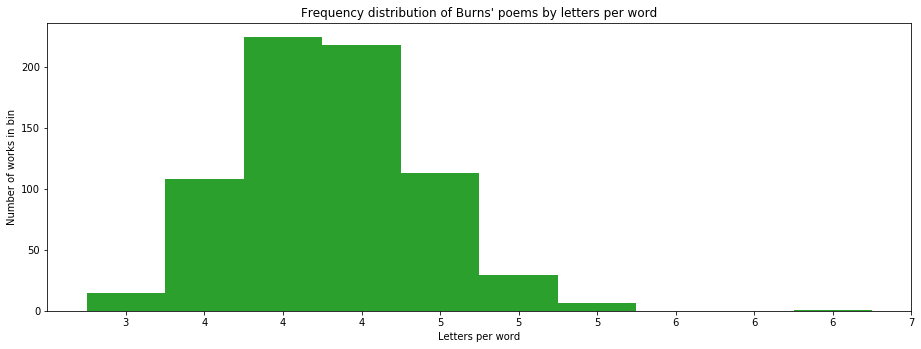

In [74]:
# Generate frequency distribution plot of Burns' poems by average letters per word
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
plt.hist(works_df["letters per word"])
ax.set_title("Frequency distribution of Burns' poems by letters per word")
ax.set_xlabel('Letters per word')
ax.set_ylabel('Number of works in bin')
bin_starts = plt.hist(works_df["letters per word"])[1]
bin_frequencies = plt.hist(works_df["letters per word"])[0]
bin_width = bin_starts[1]-bin_starts[0]
bin_middles = [x + bin_width/2 for x in bin_starts]
ax.xaxis.set_ticks(bin_middles)
ax.xaxis.set_ticklabels(['%1.f' % x for x in bin_middles])

plt.show()

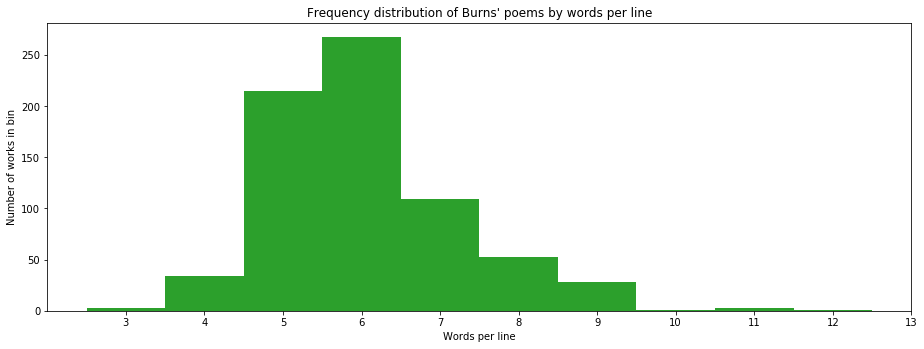

In [75]:
# Generate frequency distribution plot of Burns' poems by average words per line
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
plt.hist(works_df["words per line"])
ax.set_title("Frequency distribution of Burns' poems by words per line")
ax.set_xlabel('Words per line')
ax.set_ylabel('Number of works in bin')
bin_starts_2 = plt.hist(works_df["words per line"])[1]
bin_frequencies_2 = plt.hist(works_df["words per line"])[0]
bin_width_2 = bin_starts_2[1]-bin_starts_2[0]
bin_middles_2 = [x + bin_width_2/2 for x in bin_starts_2]
ax.xaxis.set_ticks(bin_middles_2)
ax.xaxis.set_ticklabels(['%1.f' % x for x in bin_middles_2])

plt.show()

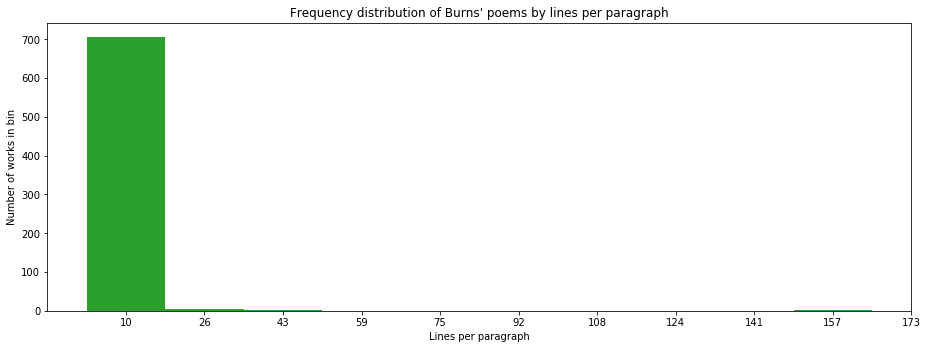

In [76]:
# Generate frequency distribution plot of Burns' poems by average lines per paragraph
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
plt.hist(works_df["lines per paragraph"])
ax.set_title("Frequency distribution of Burns' poems by lines per paragraph")
ax.set_xlabel('Lines per paragraph')
ax.set_ylabel('Number of works in bin')
bin_starts_3 = plt.hist(works_df["lines per paragraph"])[1]
bin_frequencies_3 = plt.hist(works_df["lines per paragraph"])[0]
bin_width_3 = bin_starts_3[1]-bin_starts_3[0]
bin_middles_3 = [x + bin_width_3/2 for x in bin_starts_3]
ax.xaxis.set_ticks(bin_middles_3)
ax.xaxis.set_ticklabels(['%1.f' % x for x in bin_middles_3])

plt.show()

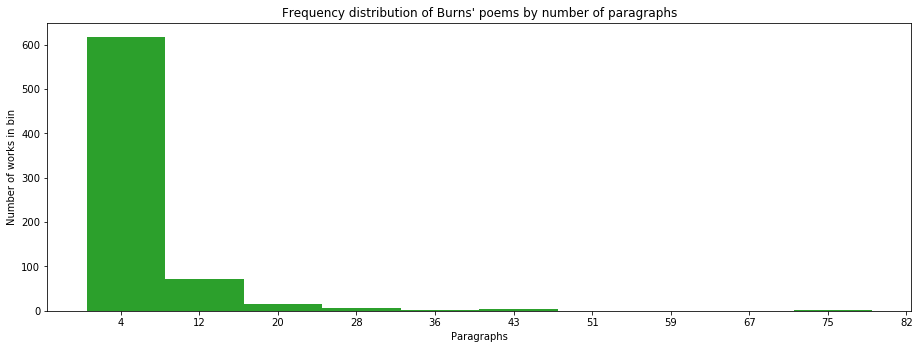

In [77]:
# Generate frequency distribution plot of Burns' poems by average paragraphs
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
plt.hist(works_df["paragraphs"])
ax.set_title("Frequency distribution of Burns' poems by number of paragraphs")
ax.set_xlabel('Paragraphs')
ax.set_ylabel('Number of works in bin')
bin_starts_4 = plt.hist(works_df["paragraphs"])[1]
bin_frequencies_4 = plt.hist(works_df["paragraphs"])[0]
bin_width_4 = bin_starts_4[1]-bin_starts_3[0]
bin_middles_4 = [x + bin_width_4/2 for x in bin_starts_4]
ax.xaxis.set_ticks(bin_middles_4)
ax.xaxis.set_ticklabels(['%1.f' % x for x in bin_middles_4])

plt.show()

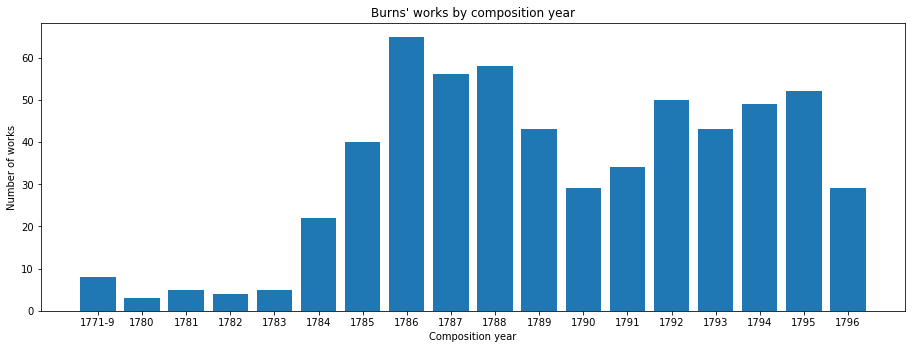

In [80]:
# Generate plot showing number of works produced by Burns per year
years_data = works_df["year"].value_counts().sort_index()
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(years_data.index, years_data)
ax.set_title("Burns' works by composition year")
ax.set_xlabel('Composition year')
ax.set_ylabel('Number of works')
plt.show()

## Text Analysis: Document Similarity

Machine learning models require arbitrary data like text documents or images to be supplied as numerical features. This process is called feature extraction. The two most commonly used methods for feature extraction from text documents are Count Vectorisation and TF-IDF Vectorisation. Count Vectorization is inherently biased towards more frequent terms as it simply counts the number of times each term appears in a given document. This is called term frequency (TF). TF-IDF Vectorisation, on the other hand, weights the term's frequency with its inverse document frequency (IDF), to reduce the impact of frequent but potentially less interesting words. (6.2. Feature extraction — scikit-learn 0.24.0 documentation, 2020)

Let TF(t, d) be the term frequency of a given term t in a given document d, n the number of documents in a corpus, and DF(t) the number of documents in the corpus that contain term t. The IDF and consequently the IF-IDF can be calculated as follows:
<br><br>
$$IDF(t) = \log\frac{n}{DF(t) + 1}$$
<br>
$$TF-IDF(t,d) = TF(t,d) * \log\frac{n}{DF(t) + 1}$$
<br><br>

One option to implement this in Python is using Scikit-Learn's CountVectorizer and then TfidfTransformer. However, Scikit-Learn also provides a TfidfVectorizer which computes all required steps at once. This is why in this report, TfidfVectorizer was used to produce the TF-IDF.

As is the case with the Burns' corpus investigated in this report, documents of the same corpus often vary in length. Ladd therefore suggests to "use the distance measure that disregards differences in magnitude and focuses on the proportions of features" (Ladd, 2020). Rather than with the exact position of the vectors, cosine similarity is only concerned with their orientation.

Another argument in favour of the cosine similarity is presented by Han, who states that due to the nature of term-frequency vectors which often contain sparse numeric data (many 0 values where documents do not share a term), many traditional distance measures, such as Euclidean or Manhattan distance, are not an ideal choice for establishing the similarity between documents. As not sharing words (i.e. having 0 values in common) does not make two (or more) documents similar, the appropriate measure for establishing document similarity in text analysis is one that disregards such 0 matches and focuses on those terms that the documents do have in common. One such  measure is cosine similarity, which was used in this report to compute document similarity. (Han, 2011)

When two vectors have no match, the angle between them is 90 degrees (cosine equals 0). Conversely, when two vectors are identical, the angle between them is 0 degrees (cosine equals 1). While cosine similarity represents proximity rather than distance, i.e. the highest value represents the closest proximity, machine learning models compute the cosine distance, where the values are reversed, meaning the lowest value represents the closest proximity. 

If u and v are two vectors, and θ the angle between the vectors, then the cosine distance is:
<br><br>
$$ 1 - \frac{u \cdot v}{||u||_2 ||v||_2} $$
or <br><br>
$$ 1−\cos(θ) $$ 


(scipy.spatial.distance.pdist — SciPy v1.5.4 Reference Guide, 2020)

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import pdist, squareform

In [60]:
# Create lists containing texts of all works, and list of titles of all works
corpus = [work['clean text'] for work in all_works_details.values()]
filekeys = [work['title'] for work in all_works_details.values()]

In [61]:
# Generate term frequency inverse document frequency
tfidf_vectorizer = TfidfVectorizer(stop_words="english", ) 
tfidf = tfidf_vectorizer.fit_transform(corpus).toarray()

# Create square-form distance matrix (Cosine distance), create Pandas DataFrame
cosine_distances = squareform(pdist(tfidf, metric='cosine'))
cosine_distances_df = pd.DataFrame(cosine_distances, index=filekeys, columns=filekeys)
cosine_distances_df

,A Ballad [While prose work and rhymes],A Bard's Epitaph,A dedication to Gavin Hamilton Esq,A Dream,A Fiddler In The North,A Fragment,A Fragment [Ballad on the American War],A Fragment [On Glenriddel's Fox breaking his chain],A Fragment [When first I came to Stewart Kyle],A Grace After Dinner,...,Winter A Dirge,Written In Friars' Carse Hermitage,Written Under The Picture of the Celebrated Miss Burns,"Ye hae lien wrang, Lassie",Ye Jacobites By Name,Ye'se get a hole to hide it in,Yon wild mossy mountains,"Yon, yon, yon lassie",Young Jockey was the blythest lad,"You're welcome, Willie Stewart"
A Ballad [While prose work and rhymes],0.000000,0.986045,0.920560,0.975438,0.996674,0.989997,0.988519,0.960931,0.995330,0.988154,...,0.994001,0.993454,0.964681,0.995345,0.994108,0.997474,0.992329,0.995554,0.988983,0.993006
A Bard's Epitaph,0.986045,0.000000,0.963826,0.975762,1.000000,0.997272,0.956051,0.974937,0.990569,0.994152,...,0.972557,0.958100,1.000000,0.994867,0.983537,0.948644,0.980126,0.998223,0.985210,1.000000
A dedication to Gavin Hamilton Esq,0.920560,0.963826,0.000000,0.813891,0.983988,0.971673,0.877605,0.923877,0.957540,0.966491,...,0.952978,0.948372,0.983269,0.924595,0.945020,0.855362,0.947059,0.984546,0.948793,0.972443
A Dream,0.975438,0.975762,0.813891,0.000000,0.965623,0.967403,0.934385,0.956596,0.974488,1.000000,...,0.925924,0.968237,0.941620,0.819383,0.938331,0.852772,0.939303,0.919179,0.969639,0.976711
A Fiddler In The North,0.996674,1.000000,0.983988,0.965623,0.000000,0.951310,0.929968,0.992351,1.000000,1.000000,...,0.974933,1.000000,1.000000,0.987698,1.000000,0.990199,0.995836,0.993706,0.951024,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ye'se get a hole to hide it in,0.997474,0.948644,0.855362,0.852772,0.990199,0.996440,0.981326,0.987983,0.985057,0.995045,...,0.993918,0.997459,0.957587,0.856522,0.956844,0.000000,0.998353,0.998695,0.975422,0.998663
Yon wild mossy mountains,0.992329,0.980126,0.947059,0.939303,0.995836,0.957665,0.951339,0.978371,0.982814,0.982040,...,0.984871,0.980448,0.971902,0.856019,0.989521,0.998353,0.000000,0.865937,0.955347,0.986959
"Yon, yon, yon lassie",0.995554,0.998223,0.984546,0.919179,0.993706,0.987472,0.994618,0.995132,0.996410,1.000000,...,0.997738,0.993437,1.000000,0.929504,0.991700,0.998695,0.865937,0.000000,0.979977,1.000000
Young Jockey was the blythest lad,0.988983,0.985210,0.948793,0.969639,0.951024,0.998664,0.959329,0.979465,0.887357,1.000000,...,0.980718,0.989614,1.000000,0.932708,0.989826,0.975422,0.955347,0.979977,0.000000,0.976500


In [62]:
# Find most similar works (smallest cosine distance that's not 0)
cosine_distances_df_no_zeros = cosine_distances_df.replace([0.000000], value=np.nan)
row_min_index = cosine_distances_df_no_zeros.idxmin(axis=0, skipna=True)
row_min_value = cosine_distances_df_no_zeros.min(skipna=True)
most_similar = pd.concat([row_min_index, row_min_value], axis=1).rename(columns={0:'most similar poem', 1:'distance'})
most_similar = most_similar.sort_values('distance').iloc[::2, :][:30]
most_similar

,most similar poem,distance
Bonie Bell,My Bonie Bell,0.009391
Epigram Addressed To An Artist,To a painter,0.017990
The Jolly Beggars : Merry Andrew,The Jolly Beggars : Sir Wisdom's a fool when h...,0.025992
Sketch,Poem On Pastoral Poetry,0.043050
The Banks O' Doon (First Version),The Banks O' Doon (Second Version),0.060676
A Lass Wi A Tocher,Hey for a Lass wi' a Tocher,0.080519
Epitaph on D- C-,On a Suicide One,0.118655
A Grace After Dinner,Grace after Meat,0.136084
The Twa Herds,The Holy Tulzie,0.152968
Scotish Ballad,The Braw Wooer,0.160364


In [63]:
# Calculate average cosine distance
no_of_similar_poems = len(cosine_distances_df_no_zeros.index)

avg_cosine_distance = cosine_distances_df_no_zeros.sum(skipna=True).sum()/(no_of_similar_poems**2 - no_of_similar_poems)
print(f'The average cosine distance is {avg_cosine_distance:.4f}.')

The average cosine distance is 0.9771.


In [64]:
# Calculate inverse document frequency
idf = tfidf_vectorizer.idf_ 

# Get a list of unique words
unique_words_list = tfidf_vectorizer.get_feature_names() 
unique_words_count = len(unique_words_list)
print(f'There are {unique_words_count} unique words in this corpus of works by Burns, excluding stop words.')

# Convert words and inverse document frequency lists into dictionary, create Pandas DataFrame
word_idfs_dict = dict(zip(unique_words_list,idf))
word_idfs_df = pd.DataFrame.from_dict(word_idfs_dict, orient='index', columns=['Inverse Document Frequency'])

word_idfs_df.sort_values(by=['Inverse Document Frequency']).iloc[0:20]

There are 12484 unique words in this corpus of works by Burns, excluding stop words.


,Inverse Document Frequency
er,1.814778
wi,1.924706
ye,1.982693
ll,2.052219
heart,2.265412
thou,2.305822
like,2.310990
sae,2.342572
man,2.408894
thy,2.437882


## Discussion

Based on the maximum and minimum of the 'words', 'lines' and 'paragraphs' (stanzas) features, it was established which works are the longest and shorted in this collection of Burns' works, "The Jolly Beggars : Love and Liberty - A Cantata" being the longest (with 79 stanzas, 364 lines and 2237 words) and "Epigram. Another On The Said Occasion" being the shortest (with 1 stanzas, 2 lines and 7 words). These statistics also represent the range for the features 'words', 'lines' and 'paragraphs'; the works in this corpus range from 1 to 79 stanzas, 2 to 364 lines and 7 to 2237 words, with a mean of 5, 31, and 190, respectively, as well as a median of 4, 21, and 131, respectively. It can be deduced that Burns' works are structurally dissimilar and he did not obviuosly favour a certain form.

As is already implied by the fact that the median of all numerical data features is smaller than the mean, the distribution of the data is positively skewed. This was investigated further through exemplary histograms for the 'letters per word', 'words per line', 'lines per paragraph', and 'paragraphs', the first three of which were calculated in order to normalise the shorter and longer works and make them more comparable. The distributions of 'letters per word' and 'words per line', resemble a normal distribution much more closely, in comparison with the distribution of 'lines per paragraph' and 'paragraphs', which are positively skewed.

A bar chart of the number of works by composition year shows that majority of the works in this corpus were composed between 1784 and 1796, and that, if this can be considered a representative sample of Burns' works, Burns' most productive year was 1786 (when Burns was aged 27), with 65 works. These numbers coincide with his biography. The fact that the majority of Burns' works were written over a longer period of time may provide some context for interpreting the apparent structural dissimilarity of his works.

Comparing his 'popular works' with other works (not listed under popular works on the BBC website) shows that those works that are considered popular are on average longer. However, the standard deviation for the popular works is higher (apart from for the number of paragraphs), indicating a bigger spread of the data points and hence a less homogeneous picture when it comes to the length of these works. While this is an indication that works are not favoured because of their length (or shortness), whether there is a statistically significant relationship between the length of a work by Burns and its popularity or not cannot be ascertained solely from this - further statistical analysis and ideally more data would be required. Moreover, the methodology for including works in the popular works list is not known. Ideally, the classification of works as popular would be based on multiple sources, which was out of scope for this report but could be a possible extension in the future.

As per the cosine distance matrix, the average cosine distance is 0.9771. Since this number is very near 1, it can be established that on average, the text in the documents examined in this report is quite dissimilar. A more detailed analysis to establish which works have the highest degree of similarity shows that the corpus contains quite a few cases of multiple near identical versions of the same work under different titles, which, in some cases, cannot easily be established from the title (e.g. "Sketch" vs. "Poem on Pastoral Poetry"). Removing near duplicates of the same work from the corpus and repeating the analysis with the adjusted corpus would ensure that the more informative similarities are being prioritised. The fact that despite the existence of near duplicates, the cosine distance is near 1, only emphasises that Burns' works are lexically diverse.

There are 12,484 unique words in this corpus of works by Burns, excluding English stop words (as per Scikit-Learn's built-in stop word list). Amongst the most common terms are the nouns 'heart' and 'love'. There is no term (that is not a stop word) and has been used in all works. Scikit-Learn admit to several known issues with their English stop words list and recommend the use of an an alternative to ensure that the results are not affected by these issues. (scipy.spatial.distance.pdist — SciPy v1.5.4 Reference Guide, 2020) One option would be to provide a custom stop words list which would also cover Scots dialect stop words; since Burns wrote his poems in English with a Scots dialect some terms that would be considered stop words remain in the unique words list and result in legitimate (non-stop) words ranking lower in the list when ordered by term frequency. While fine-tuning the stop words approach is out of scope for the current analysis, it should be considered for any future work on this corpus.

## Conclusion and Further Work

This analysis of a Robert Burns' corpus containing more than 700 works has shown that Burns didn't favour a certain form or vocabulary, as the works analysed are both structurally and lexically quite dissimilar. 

Certain constraints and weaknesses have been highlighted which could lead to further work, including a more pluralistic approach to establishing popularity of his works, identifying and removing near duplicate works that were published under different titles, and refining term frequency analysis by accounting for Scots English stop words. 

Furthermore, a similarity analysis between the works written in the same year could be interesting, as could be an analysis of how form and vocabulary evolved over time. Since most of Burns' works were written to be either sung or read aloud, analysing the available audio files may provide additional insights. The data source provides a theme and location for most works. While the methodology for extracting this was not provided - and it may well have been done manually - it would be interesting to see if an analysis using machine learning techniques to extract the theme would come to the same conclusions. Mapping the locations of Burns' works, potentially against other features such as year or theme, could also provide interesting insights. Lastly, in a further analysis, it could be established what the precentage of non-Scots dialect specific words for each work is.

## References

Docs.scipy.org. 2020. Scipy.Spatial.Distance.Pdist — Scipy V1.5.4 Reference Guide. [online] Available at: <https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html> [Accessed 28 December 2020].

Han, J., 2011. Data Mining. Burlington: Morgan Kaufmann.

Ladd, J., 2020. Understanding And Using Common Similarity Measures For Text Analysis. [online] Programminghistorian.org. Available at: <https://programminghistorian.org/en/lessons/common-similarity-measures> [Accessed 29 December 2020].

Scikit-learn.org. 2020. Sklearn.Feature_Extraction.Text.Countvectorizer — Scikit-Learn 0.24.0 Documentation. [online] Available at: <https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html> [Accessed 29 December 2020].